In [2]:
from langchain_core.prompts import ChatPromptTemplate,PromptTemplate
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.document_loaders import TextLoader
from langchain_ollama import OllamaEmbeddings
from pydantic import BaseModel,Field
from langchain.vectorstores import Chroma, FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [3]:
llm = ChatGroq(model_name="deepseek-r1-distill-llama-70b")

In [4]:
import os
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_aPI_KEY")

from langchain_ollama import OllamaEmbeddings
embeddings = OllamaEmbeddings(model="llama3.2:latest")

In [5]:
loader=TextLoader(file_path=r"C:\Users\ADMIN\OneDrive\Desktop\Git\END-TO_END_LANGGRAPH\END-TO_END_LANGGRAPH\indian_economic.txt")
docs = loader.load()
text_spliter = RecursiveCharacterTextSplitter(chunk_size=300,chunk_overlap=50)
new_doc = text_spliter.split_documents(documents=docs)

In [ ]:
db = Chroma.from_documents(new_doc, embeddings, persist_directory="./chroma_db")


In [23]:
retriver = db.as_retriever(search_kwargs={"k":3})

In [43]:
query = "what is llama3?"
docs = retriver.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)
print(docs)

for doc in docs:
    print(doc)

{'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}
Key Sector Performances:
[Document(metadata={'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}, page_content='Key Sector Performances:'), Document(metadata={'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}, page_content='Year\tGDP\n2022\t$3,517.24B\n2021\t$3,173.04B\n2020\t$2,935.57B\n2019\t$2,869.45B\n2018\t$2,715.50B\n2017\t$2,652.10B\n2016\t$2,479.15B\n2015\t$2,390.78B'), Document(metadata={'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}, page_content='Additional Economic Indicators:')]
page_content='Key Sector Performances:' metadata={'source': 'C:\\Users\\ADMIN\\OneDrive\\Desktop\\Git\\END-TO_END_LANGGRAPH\\END-TO_END_LANGGRAPH\\indian_economic.txt'}
page_c

In [44]:
import operator
from typing import Sequence,Annotated,TypedDict
from langchain_core.messages import BaseMessage

In [70]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage],operator.add]

In [71]:
from pydantic import BaseModel,Field
from langchain_core.output_parsers import PydanticOutputParser

In [72]:

from pydantic import BaseModel , Field
class TopicSelectionParser(BaseModel):
    Topic: str = Field(description='Selected Topic')
    Reasoning: str = Field(description='Reasoning behind topic selection')

In [73]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

In [74]:
print(parser.get_format_instructions())

The output should be formatted as a JSON instance that conforms to the JSON schema below.

As an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}
the object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.

Here is the output schema:
```
{"properties": {"Topic": {"description": "Selected Topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}
```


In [75]:
def function_1(state):
    message=state["messages"]
    question=message[-1]
    print(question)
    
    template="""
    Your task is to classify the given user query into one of the following categories: [India, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt = PromptTemplate(template=template,
                                    input_variables=[question],
                                    partial_variables={
                                        "format_instructions" : parser.get_format_instructions()                                    }
                                    )
    chain =  prompt | llm | parser
    
    response = chain.invoke({"question":question,"format_instructions" : parser.get_format_instructions() })

    print(response)

    return {"messages": [response.Topic]}

In [76]:
state = {"messages": ["Tell me about USA Industrial Growth"]}
function_1(state)

Tell me about USA Industrial Growth
Topic='Not Related' Reasoning='The query is about USA Industrial Growth, which is not related to India.'


{'messages': ['Not Related']}

In [77]:
def router(state):
    print('-> Router ->')
    
    messages = state["messages"]
    last_message = messages[-1]
    print(last_message)
    if 'India' in last_message:
        return 'RAG Call'
    else:
        return 'LLM Call'

In [78]:
def function_2(state):
    print('-> Calling RAG ->')
    messages = state['messages']
    question = messages[0] ## Fetching the user question
    print(question)

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)
    
    print(prompt)

    retrieval_chain = (
        {"context": retriver, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return  {"messages": [result]}

In [79]:

def function_3(state):
    print('-> Calling LLM ->')

    messages = state['messages']
    question = messages[0] ## Fetching the user question

    # Normal LLM call
    complete_query = "Anwer the follow question with your knowledge of the real world. Following is the user question: " + question
    response = llm.invoke(complete_query)
    return {"messages": [response.content]}

In [80]:
state = {"messages": ["Tell me about USA Industrial Growth"]}
function_3(state)

-> Calling LLM ->


{'messages': ["<think>\nOkay, so I need to understand the industrial growth of the USA. Let me start by breaking down the question. The user wants to know about the history and development of industries in the United States. I remember that the USA has gone through several phases of industrialization, so I should probably structure the answer chronologically.\n\nFirst, I think about the 19th century. The Industrial Revolution began in Britain, but the USA caught up quickly. There were major advancements like the steam engine, which must have been important. Also, the construction of railroads expanded transportation, which is crucial for moving goods and people. Textile mills were among the first factories, so that's another point. The Civil War probably played a role too, maybe by accelerating industrial production for the war effort.\n\nMoving into the late 19th and early 20th centuries, I recall hearing about robber barons and big industries like steel and oil. Andrew Carnegie and J

In [81]:
from langgraph.graph import StateGraph,END

workflow5 = StateGraph(AgentState) ### StateGraph with AgentState


workflow5.add_node("agent", function_1)

workflow5.add_node("RAG", function_2)

workflow5.add_node("LLM", function_3)


workflow5.set_entry_point("agent")

workflow5.add_conditional_edges(
    "agent",
    
    
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    }
)

workflow5.add_edge("RAG",END)


workflow5.add_edge("LLM",END)


app5=workflow5.compile()

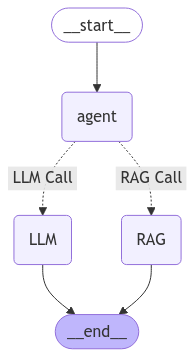

In [82]:
app5

In [83]:
state = {"messages": ["Tell me about india Industrial Growth"]}

In [84]:
output = app5.invoke(state)

Tell me about india Industrial Growth
Topic='India' Reasoning="The query explicitly mentions 'india Industrial Growth', which is directly related to India's economic and industrial development."
-> Router ->
India
-> Calling RAG ->
Tell me about india Industrial Growth
input_variables=['context', 'question'] input_types={} partial_variables={} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='Answer the question based only on the following context:\n    {context}\n\n    Question: {question}\n    '), additional_kwargs={})]


In [85]:
print(output)

{'messages': ['Tell me about india Industrial Growth', 'India', '<think>\nOkay, so I need to figure out how to answer the question about India\'s industrial growth based on the provided context. Let me start by reading through the context carefully. \n\nThe context has three documents. The first one mentions "Key Sector Performances," which seems like it\'s about different sectors but doesn\'t provide specific details. The second document has a table with GDP figures from 2015 to 2022. I can see that the GDP has been increasing each year, which is a good indicator of economic growth. For example, in 2015, the GDP was $2,390.78B, and by 2022, it rose to $3,517.24B. That\'s a significant increase over seven years, which suggests steady growth.\n\nThe third document talks about specific sectors: Automotive and Pharmaceuticals. The Automotive sector saw a 3.2% increase in output in January, driven by electric vehicles and two-wheelers. Pharmaceuticals exports grew by 1.8%, thanks to generi